Capstone Project:

(101903740) KRITIKA JAIN

(101903687) RIYA MITTAL

(101903686) SAMEER MAHAJAN

(101903674) PRANJAL BHATT

BE Fourth Year, CoE

CPG No: _113_

Under the Mentorship of

Dr. Anupam Garg

In [ ]:
## Reducing Random Variations
import numpy as np
SEED = 321
SMOTE_SEED = 432
np.random.seed(SEED)

#### Using Custom PyPi Package - `fsds`


In [ ]:
 !pip install -U fsds
from fsds.imports import *

fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [ ]:
%load_ext autoreload
%autoreload 2
import bs_ds_local as bs
import project_functions as ji

In [ ]:
## Set Pandas Options
import pandas as pd
# pd.set_eng_float_format(accuracy=2)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
pd_options = {
    'display.max_rows'    : 200,
    'display.max_info_rows':200,
    'display.max_columns' : 0,
}
[pd.set_option(option, setting) for option, setting in pd_options.items()]

## Visualization Packages and Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# !pip isntall missingno
import missingno as ms

# %conda install -c conda-forge shap
import shap
shap.initjs()

## Set Plot Style
plt.style.use('seaborn-notebook')
# sns.set_context(font_scale=2)

## Suppress Warnings
# import warnings
# warnings.filterwarnings('ignore')


## version check
import sklearn
import xgboost as xgb

print(f"Matplotlib Version: {mpl.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")
print(f"XGBoost Version: {xgb.__version__}")
print(f"Shap Version: {shap.__version__}")

Matplotlib Version: 3.3.1
Pandas Version: 1.3.0
Numpy Version: 1.19.5
Seaborn Version: 0.11.0
Scikit-learn Version: 0.23.2
XGBoost Version: 1.3.3
Shap Version: 0.37.0


In [ ]:
## Preprocessing & Modeling Imports
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler,RobustScaler,
                                   OneHotEncoder)
from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.svm import LinearSVC,SVC

import joblib,os
from sklearn.base import clone
from sklearn import set_config
set_config(display='diagram')

##  PROJECT CONTROL BOOLEAN ARGS

In [ ]:
### PROJECT CONTROL BOOLS

## 1. Data Source
# Control if data downloaded fresh from Iowa gov api or original kaggle versin
USE_ORIG_DATA = False 

## if USE_ORIG_DATA==False, download new csv from API or use previous downloaded
GET_NEW_DATA = False

if USE_ORIG_DATA==True &  GET_NEW_DATA==True:
    raise Exception('Only one of [USE_ORIG_DATA, GET_NEW_DATA] may be True')

## 2. Gridsearches
# Control if run new gridsearch or use previous params
RUN_SEARCHES = True


## Loading the dataset and removing unrelated columns

In [ ]:
## Set project booleans above to change data source used
if USE_ORIG_DATA:
    file = 'data/3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa.csv'
    print(f'Using original data: {file}')
    df = pd.read_csv(file)
    
    ## Making snake case column names if using orignal Kaggle dataset
    snake_case_cols = [c.lower().strip().replace(' - ',' ').replace(' ','_') for c in df.columns]

    ## clean up additional changes made to col names
    list_of_updates = [('classification','class'),
                       ('days_to_return','days_return'),
                      ('sub_type','subtype')]
    ## Fix changes in naming scheme
    for current,new in list_of_updates:
        snake_case_cols =[c.replace(current,new) for c in snake_case_cols]
    
    ## Make a renaming map and rename columns
    column_names_map = dict(zip(df.columns,snake_case_cols))
    df.rename(column_names_map,axis=1,inplace=True)
    
elif GET_NEW_DATA:
    url = "https://data.iowa.gov/resource/mw8r-vqy4.csv"
    print(f'Downloading data from API: {url}')
    df = pd.read_csv(url)
    
    new_file = "data/iowa-prisoner-recidivism_data-iowa-gov-api.csv"
    df.to_csv(new_file,index=False)
    print(f"- downloaded data saved as: {new_file}")

else:
    file = "data/iowa-prisoner-recidivism_data-iowa-gov-api.csv"
    df = pd.read_csv(file)
    print(f'Using preivous api download: {file}' )

df.head()

Using preivous api download: data/iowa-prisoner-recidivism_data-iowa-gov-api.csv


,fiscal_year_released,recidivism_reporting_year,main_supervising_district,release_type,race_ethnicity,age_at_release,sex,offense_class,offense_type,offense_subtype,return_to_prison,days_return,recidivism_type,new_offense_class,new_offense_type,new_offense_subtype,target_population
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,433.00,New,C Felony,Drug,Trafficking,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,453.00,Tech,NaN,NaN,NaN,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,832.00,Tech,NaN,NaN,NaN,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,116.00,Tech,NaN,NaN,NaN,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   fiscal_year_released       int64  
 1   recidivism_reporting_year  int64  
 2   main_supervising_district  object 
 3   release_type               object 
 4   race_ethnicity             object 
 5   age_at_release             object 
 6   sex                        object 
 7   offense_class              object 
 8   offense_type               object 
 9   offense_subtype            object 
 10  return_to_prison           object 
 11  days_return                float64
 12  recidivism_type            object 
 13  new_offense_class          object 
 14  new_offense_type           object 
 15  new_offense_subtype        object 
 16  target_population          object 
dtypes: float64(1), int64(2), object(14)
memory usage: 132.9+ KB


In [ ]:
## Check years included 
df[[c for c in df.columns if 'year' in c]].agg(['min','max'])

,fiscal_year_released,recidivism_reporting_year
min,2010,2013
max,2014,2017


In [ ]:
## Drop cols related to recivism details 
drop_expr = ['new',"days","recidivism_type","year"]
drop_cols = []
for exp in drop_expr:
    drop_cols.extend([col for col in df.columns if exp in col])
drop_cols

['new_offense_class',
 'new_offense_type',
 'new_offense_subtype',
 'days_return',
 'recidivism_type',
 'fiscal_year_released',
 'recidivism_reporting_year']

In [ ]:
## Saving removed columns to merge again after feature engineering (for tableau)
removed_df = df[drop_cols].copy()
removed_df

,new_offense_class,new_offense_type,new_offense_subtype,days_return,recidivism_type,fiscal_year_released,recidivism_reporting_year
0,C Felony,Drug,Trafficking,433.00,New,2010,2013
1,NaN,NaN,NaN,453.00,Tech,2010,2013
2,NaN,NaN,NaN,832.00,Tech,2010,2013
3,NaN,NaN,NaN,NaN,No Recidivism,2010,2013
4,NaN,NaN,NaN,116.00,Tech,2010,2013
...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,No Recidivism,2010,2013
996,NaN,NaN,NaN,NaN,No Recidivism,2010,2013
997,NaN,NaN,NaN,NaN,No Recidivism,2010,2013
998,NaN,NaN,NaN,NaN,No Recidivism,2010,2013


In [ ]:
df.drop(columns=drop_cols,inplace=True)
df.head()

,main_supervising_district,release_type,race_ethnicity,age_at_release,sex,offense_class,offense_type,offense_subtype,return_to_prison,target_population
0,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,Yes
1,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,No
2,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,Yes
3,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,Yes
4,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,No


### Save original names vs short names in column_legend
- then map names onto columns

In [ ]:
# ## Replacing columns with short names
# rename_map = {
#     'Fiscal Year Released': 'yr_released',
#     'Recidivism Reporting Year': 'report_year' ,
#     'Main Supervising District': 'supervising_dist' ,
#     'Release Type': 'release_type' ,
#     'Race - Ethnicity': 'race_ethnicity'  ,
#     'Age At Release ':  'age_at_release' ,
#     'Sex':'sex'   ,
#     'Offense Classification': 'offense_class' ,
#     'Offense Type': 'crime_type'  ,
#     'Offense Subtype':  'crime_subtype' ,
#     'Return to Prison': 'recidivist'  ,
#     'Target Population':  'target_pop'
# }

# df = df.rename(rename_map,axis=1)
# df

In [ ]:
df.to_csv('data/iowa_recidivism_renamed_2021.csv')

In [ ]:
## Explore Dtypes and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   main_supervising_district  object
 1   release_type               object
 2   race_ethnicity             object
 3   age_at_release             object
 4   sex                        object
 5   offense_class              object
 6   offense_type               object
 7   offense_subtype            object
 8   return_to_prison           object
 9   target_population          object
dtypes: object(10)
memory usage: 78.2+ KB


In [ ]:
import missingno as ms

def column_report(df,perc_null_thresh=5,return_report=False):
    """Returns a dataframe with the following summary information
    for each column in df.
    - Dtype
    - # Unique Entries
    - # Null Values
    - # Non-Null Values
    - % Null Values
    """
    report = pd.DataFrame({
        'nunique':df.nunique(),
        'dtype':df.dtypes, 
        '# Non-Null': df.notnull().sum(),
        '# Nulls': df.isna().sum(),
        '% Nulls':df.isna().sum()/len(df)*100,
        })
    
    report = report.reset_index().rename({'index':'column'},axis=1)
    
    if return_report:
        return report#.round(2)    
    else:
        def style_nulls(v, thresh=perc_null_thresh, props=''):
            return props if v > thresh else None
        s2 = report.style.applymap(style_nulls, props='color:red;',subset=['% Nulls'])\
                        .format(lambda x: f"{x:.2f} %",subset=['% Nulls'])\
                        .set_caption("Column Report")
        display(s2)
    



def nulls_report(df,plot=True):
    """Displays a series of null values for any columns with >0 nulls"""
    nulls= df.isna().sum()
    nulls_only = nulls[nulls>0]
    nulls_only = nulls_only.round(2)
    
    
    if plot:
        with plt.style.context('seaborn-poster'):
            ms.matrix(df,figsize=(10,4))
            plt.show()
        
    print('Columns with Null Values:')
    display(nulls_only)#.style.format(lambda x: f"{x:.2f} %",
#                                                       subset=['%']))

  

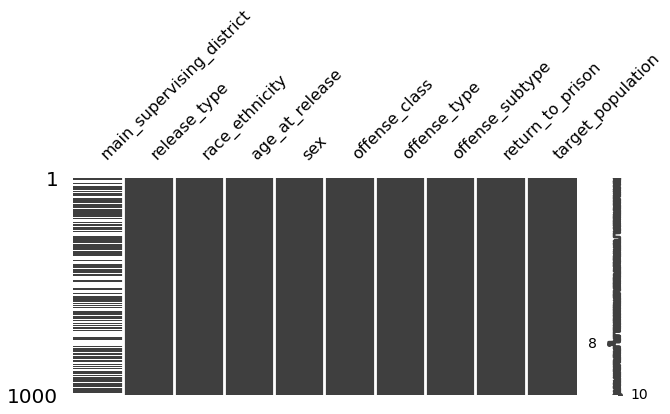

Columns with Null Values:


main_supervising_district    447
release_type                   2
dtype: int64

In [ ]:
nulls_report(df)

**Results of Null Check**
<!-- - race_ethnicity has 30 (0.12% of data)
    -  drop
- age_at_release has 3 (0.01% of data)
    - drop
- sex has 3 (0.01% of data)
    - drop -->
- main_supervising_district has 9581(36.82% of data)
    - replace with "unknown"
- release_type has 1762 (6.77% of data)
    - drop
    
**Dropping all null values from age_at_release, race_ethnicity, and release_type.**

In [ ]:
    
column_report(df)

,column,nunique,dtype,# Non-Null,# Nulls,% Nulls
0,main_supervising_district,8,object,553,447,44.70 %
1,release_type,3,object,998,2,0.20 %
2,race_ethnicity,8,object,1000,0,0.00 %
3,age_at_release,5,object,1000,0,0.00 %
4,sex,2,object,1000,0,0.00 %
5,offense_class,8,object,1000,0,0.00 %
6,offense_type,5,object,1000,0,0.00 %
7,offense_subtype,24,object,1000,0,0.00 %
8,return_to_prison,2,object,1000,0,0.00 %
9,target_population,2,object,1000,0,0.00 %


In [ ]:
def value_counts(col,dropna=False,normalize=True,sort_index=False,rename=True):
    """Convenience function for display value counts with default params"""
    counts =  col.value_counts(dropna=dropna,normalize=normalize)
    if sort_index:
        counts.sort_index(inplace=True)
        
    if rename:
        counts.name=f'{counts.name}.value_counts(normalized={normalize}, dropna={dropna})'
    return counts

In [ ]:
## inspect categories
dashes = '---'*20
for col in df.columns:
    print(dashes)
    print(f"Value Counts for {col}:")
    display(value_counts(df[col],normalize=False,rename=False))
    print()

------------------------------------------------------------
Value Counts for main_supervising_district:


NaN    447
5JD    146
1JD     90
2JD     73
8JD     68
7JD     59
3JD     41
6JD     38
4JD     38
Name: main_supervising_district, dtype: int64


------------------------------------------------------------
Value Counts for release_type:


Parole                          539
Discharged – End of Sentence    445
Special Sentence                 14
NaN                               2
Name: release_type, dtype: int64


------------------------------------------------------------
Value Counts for race_ethnicity:


White - Non-Hispanic                               665
Black - Non-Hispanic                               232
White - Hispanic                                    80
American Indian or Alaska Native - Non-Hispanic     15
Asian or Pacific Islander - Non-Hispanic             5
American Indian or Alaska Native - Hispanic          1
White -                                              1
Black - Hispanic                                     1
Name: race_ethnicity, dtype: int64


------------------------------------------------------------
Value Counts for age_at_release:


25-34           342
35-44           250
45-54           187
Under 25        180
55 and Older     41
Name: age_at_release, dtype: int64


------------------------------------------------------------
Value Counts for sex:


Male      901
Female     99
Name: sex, dtype: int64


------------------------------------------------------------
Value Counts for offense_class:


D Felony                                 426
C Felony                                 273
Aggravated Misdemeanor                   158
Felony - Enhanced                         67
B Felony                                  66
Serious Misdemeanor                        7
Other Felony (Old Code)                    2
Sexual Predator Community Supervision      1
Name: offense_class, dtype: int64


------------------------------------------------------------
Value Counts for offense_type:


Drug            326
Property        316
Violent         223
Public Order    123
Other            12
Name: offense_type, dtype: int64


------------------------------------------------------------
Value Counts for offense_subtype:


Trafficking                        267
Theft                              140
Assault                            113
Burglary                            92
Sex                                 60
Forgery/Fraud                       59
OWI                                 52
Drug Possession                     33
Other Drug                          26
Traffic                             24
Other Violent                       21
Sex Offender Registry/Residency     21
Murder/Manslaughter                 18
Arson                               12
Vandalism                           12
Robbery                             11
Alcohol                             11
Weapons                              9
Other Criminal                       9
Flight/Escape                        5
Special Sentence Revocation          2
Kidnap                               1
Stolen Property                      1
Prostitution/Pimping                 1
Name: offense_subtype, dtype: int64


------------------------------------------------------------
Value Counts for return_to_prison:


No     710
Yes    290
Name: return_to_prison, dtype: int64


------------------------------------------------------------
Value Counts for target_population:


Yes    553
No     447
Name: target_population, dtype: int64

In [ ]:
# col = 'offense_subtype'
# ax = df[col].value_counts(1).plot(kind='bar',figsize=(8,4))
# ax.set(ylabel='% of Observations',xlabel='Category',
#        title=f'Value Counts for {col}')
# ax.axhline(.05,c='red',label='5% cutoff')
# ax.legend();

In [ ]:
def plot_rare_labels(df,col = 'offense_subtype',
                     thresh=.01,report=True):
    
    ## PLot value counts
    counts = df[col].value_counts(1)
    
    ax = counts.plot(kind='bar',figsize=(8,4))
    ax.set(ylabel='% of Observations',xlabel='Category',
           title=f'Value Counts for {col}')
    ax.axhline(thresh,c='red',label=f'{thresh*100:.2f}% cutoff')
    ax.legend();
    
    ## get list of rare/non-rare
    rare = counts[counts<thresh]
    if report:
        plt.show()
        
        if len(rare)>0:
            print(f'[i] Rare Labels Present in {col}:')
            print(rare)
        else:
            print(f'[i] No Rare Labels Present in {col}.')
        

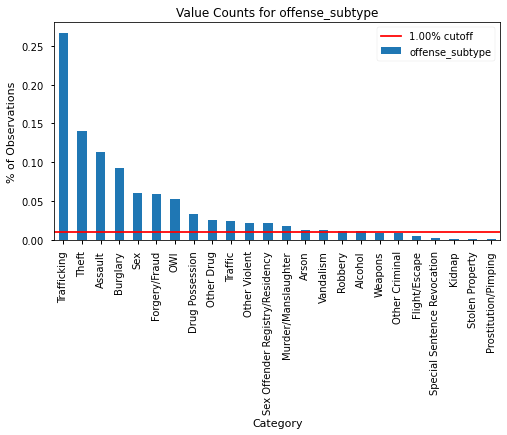

[i] Rare Labels Present in offense_subtype:
Weapons                       0.01
Other Criminal                0.01
Flight/Escape                 0.01
Special Sentence Revocation   0.00
Kidnap                        0.00
Stolen Property               0.00
Prostitution/Pimping          0.00
Name: offense_subtype, dtype: float64


In [ ]:
plot_rare_labels(df,col='offense_subtype',thresh=0.01);

### Making `age_at_release` numerical

In [ ]:
value_counts(df['age_at_release'])#.value_counts(dropna=False)

25-34          0.34
35-44          0.25
45-54          0.19
Under 25       0.18
55 and Older   0.04
Name: age_at_release.value_counts(normalized=True, dropna=False), dtype: float64

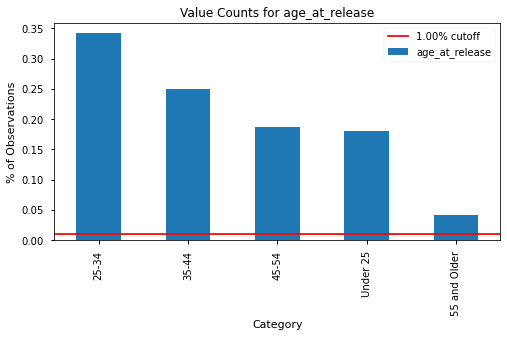

[i] No Rare Labels Present in age_at_release.


In [ ]:
plot_rare_labels(df,'age_at_release')

In [ ]:
# converting age to numeric feature
age_num_map = {'Under 25':20,
              '25-34':30, 
              '35-44':40,
              '45-54':50,
              '55 and Older':70}
df['age_at_release'] = df['age_at_release'].map(age_num_map)
value_counts(df['age_at_release'])

30   0.34
40   0.25
50   0.19
20   0.18
70   0.04
Name: age_at_release.value_counts(normalized=True, dropna=False), dtype: float64

### df['race_ethnicity']

In [ ]:
value_counts(df['race_ethnicity'],normalize=False)

White - Non-Hispanic                               665
Black - Non-Hispanic                               232
White - Hispanic                                    80
American Indian or Alaska Native - Non-Hispanic     15
Asian or Pacific Islander - Non-Hispanic             5
American Indian or Alaska Native - Hispanic          1
White -                                              1
Black - Hispanic                                     1
Name: race_ethnicity.value_counts(normalized=False, dropna=False), dtype: int64

- **Remapping race_ethnicity**
    - Due to the low numbers for several of the race_ethnicity types, reducing and combining Hispanic and Non-Hispanic groups
    - Alternative approach of separating race and ethnicity into 2 separate features was rejected after modeling

In [ ]:
# df['race_ethnicity'].unique()

In [ ]:
# Defining Dictionary Map for race_ethnicity categories

# race_ethnicity_map = {'White - Non-Hispanic':'White',
#                         'Black - Non-Hispanic': 'Black',
#                         'White - Hispanic' : 'Hispanic',
#                         'American Indian or Alaska Native - Non-Hispanic' : 'American Native',
#                         'Asian or Pacific Islander - Non-Hispanic' : 'Asian or Pacific Islander',
#                         'Black - Hispanic' : 'Black',
#                         'American Indian or Alaska Native - Hispanic':'American Native',
#                         'White -' : 'White',
#                         'Asian or Pacific Islander - Hispanic' : 'Asian or Pacific Islander',
#                         'N/A -' : np.nan,
#                         'Black -':'Black'}

race_ethnicity_renamer = {'White -':'White - Non-Hispanic'}

# Replacing original race_ethnicity column with remapped one.
df['race_ethnicity'] = df['race_ethnicity'].replace(race_ethnicity_renamer)
value_counts(df['race_ethnicity'])

White - Non-Hispanic                              0.67
Black - Non-Hispanic                              0.23
White - Hispanic                                  0.08
American Indian or Alaska Native - Non-Hispanic   0.01
Asian or Pacific Islander - Non-Hispanic          0.01
American Indian or Alaska Native - Hispanic       0.00
Black - Hispanic                                  0.00
Name: race_ethnicity.value_counts(normalized=True, dropna=False), dtype: float64

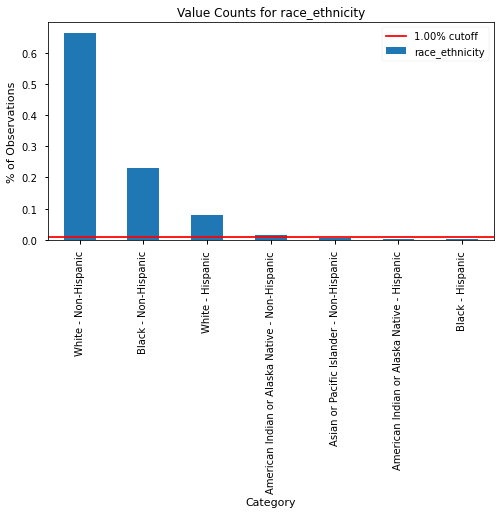

[i] Rare Labels Present in race_ethnicity:
Asian or Pacific Islander - Non-Hispanic      0.01
American Indian or Alaska Native - Hispanic   0.00
Black - Hispanic                              0.00
Name: race_ethnicity, dtype: float64


In [ ]:
plot_rare_labels(df,'race_ethnicity')

### df['offense_class']

In [ ]:
value_counts(df['offense_class'])

D Felony                                0.43
C Felony                                0.27
Aggravated Misdemeanor                  0.16
Felony - Enhanced                       0.07
B Felony                                0.07
Serious Misdemeanor                     0.01
Other Felony (Old Code)                 0.00
Sexual Predator Community Supervision   0.00
Name: offense_class.value_counts(normalized=True, dropna=False), dtype: float64

In [ ]:
# Remapping
offense_class_map = {'Other Felony (Old Code)':'Other Felony' ,#or other felony
                  'Other Misdemeanor':'Other Misdemeanor',
                   'Felony - Mandatory Minimum':'Other Felony',#np.nan, # if minimum then lowest sentence ==  D Felony
                   'Special Sentence 2005': 'Sex Offender',
                   'Other Felony' : 'Other Felony' ,
                   'Sexual Predator Community Supervision' : 'Sex Offender',
                   'D Felony': 'D Felony',
                   'C Felony' :'C Felony',
                   'B Felony' : 'B Felony',
                   'A Felony' : 'A Felony',
                   'Aggravated Misdemeanor':'Aggravated Misdemeanor',
                   'Felony - Enhancement to Original Penalty':'Felony - Enhanced',
                   'Felony - Enhanced':'Felony - Enhanced' ,
                   'Serious Misdemeanor':'Serious Misdemeanor',
                   'Simple Misdemeanor':'Simple Misdemeanor'}

df['offense_class'] = df['offense_class'].map(offense_class_map)
value_counts(df['offense_class'])

D Felony                 0.43
C Felony                 0.27
Aggravated Misdemeanor   0.16
Felony - Enhanced        0.07
B Felony                 0.07
Serious Misdemeanor      0.01
Other Felony             0.00
Sex Offender             0.00
Name: offense_class.value_counts(normalized=True, dropna=False), dtype: float64

In [ ]:
# plot_rare_labels(df, 'offense_class')

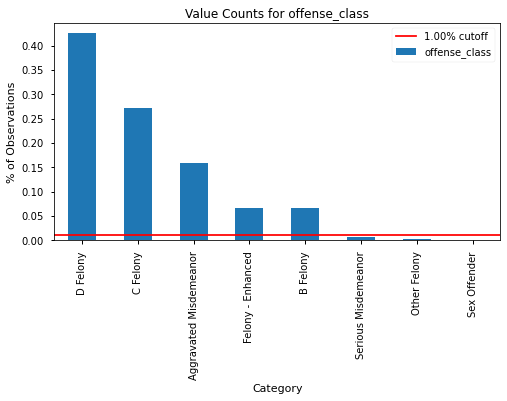

[i] Rare Labels Present in offense_class:
Serious Misdemeanor   0.01
Other Felony          0.00
Sex Offender          0.00
Name: offense_class, dtype: float64


In [ ]:
plot_rare_labels(df,'offense_class')

## Remapping Binary Cols

In [ ]:
binary_cols = df.columns[df.nunique()==2]
binary_cols

Index(['sex', 'return_to_prison', 'target_population'], dtype='object')

### 'sex'

In [ ]:
sex_map = {'Male':1, 'Female':0}
sex_map

{'Male': 1, 'Female': 0}

In [ ]:
df['sex'] = df['sex'].replace(sex_map)
df['sex'] = df['sex'].astype('category')
value_counts(df['sex'])

1   0.90
0   0.10
Name: sex.value_counts(normalized=True, dropna=False), dtype: float64

#### Remapping target

In [ ]:
value_counts(df['return_to_prison'])

No    0.71
Yes   0.29
Name: return_to_prison.value_counts(normalized=True, dropna=False), dtype: float64

In [ ]:
# # Recidivist
target_map = {'No':0,'Yes':1}
df['return_to_prison'] = df['return_to_prison'].map(target_map)
value_counts(df['return_to_prison'])

0   0.71
1   0.29
Name: return_to_prison.value_counts(normalized=True, dropna=False), dtype: float64

#### `target_pop`

In [ ]:
value_counts(df['target_population'])

Yes   0.55
No    0.45
Name: target_population.value_counts(normalized=True, dropna=False), dtype: float64

In [ ]:
df['target_population'] = df['target_population'].map( {'No':0,'Yes':1}).astype('category')
value_counts(df['target_population'])

1   0.55
0   0.45
Name: target_population.value_counts(normalized=True, dropna=False), dtype: float64

### Creating a simple 'felony' feature

In [ ]:
# Engineering a simple 'felony' true false category
df['felony'] = df['offense_class'].str.contains('felony',case=False).astype('category')
value_counts(df['felony'])

True    0.83
False   0.17
Name: felony.value_counts(normalized=True, dropna=False), dtype: float64

In [ ]:
df.dtypes

main_supervising_district      object
release_type                   object
race_ethnicity                 object
age_at_release                  int64
sex                          category
offense_class                  object
offense_type                   object
offense_subtype                object
return_to_prison                int64
target_population            category
felony                       category
dtype: object

In [ ]:
df

,main_supervising_district,release_type,race_ethnicity,age_at_release,sex,offense_class,offense_type,offense_subtype,return_to_prison,target_population,felony
0,7JD,Parole,Black - Non-Hispanic,30,1,C Felony,Violent,Robbery,1,1,True
1,NaN,Discharged – End of Sentence,White - Non-Hispanic,30,1,D Felony,Property,Theft,1,0,True
2,5JD,Parole,White - Non-Hispanic,40,1,B Felony,Drug,Trafficking,1,1,True
3,6JD,Parole,White - Non-Hispanic,30,1,B Felony,Other,Other Criminal,0,1,True
4,NaN,Discharged – End of Sentence,Black - Non-Hispanic,40,1,D Felony,Violent,Assault,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,Discharged – End of Sentence,White - Hispanic,40,1,B Felony,Drug,Trafficking,0,0,True
996,NaN,Discharged – End of Sentence,White - Hispanic,40,1,B Felony,Drug,Trafficking,0,0,True
997,NaN,Discharged – End of Sentence,White - Hispanic,40,1,B Felony,Drug,Trafficking,0,0,True
998,7JD,Parole,Black - Non-Hispanic,40,1,D Felony,Public Order,Sex Offender Registry/Residency,0,1,True


In [ ]:
# Combining crime_type and crime_subtype into types_combined
# df['offense_class_type_subtype']= df['offense_class']+'_'+df['offense_class']+'_'+df['offense_subtype']
# value_counts(df['offense_class_type_subtype'])
df.nunique()

main_supervising_district     8
release_type                  3
race_ethnicity                7
age_at_release                5
sex                           2
offense_class                 8
offense_type                  5
offense_subtype              24
return_to_prison              2
target_population             2
felony                        2
dtype: int64

### Creating a 'max_sentence' feature based on crime class max penalties
   

In [ ]:
value_counts(df['offense_class']).sort_index()

Aggravated Misdemeanor   0.16
B Felony                 0.07
C Felony                 0.27
D Felony                 0.43
Felony - Enhanced        0.07
Other Felony             0.00
Serious Misdemeanor      0.01
Sex Offender             0.00
Name: offense_class.value_counts(normalized=True, dropna=False), dtype: float64

- Unsure what Other Felony might represent. Will assume its halfway between C and D penalty

In [ ]:
# Mapping years onto crime class
offense_class_max_sentence_map = {'A Felony': 100,  # Life
                                'Aggravated Misdemeanor': 2, # 2 years
                                'B Felony': 25, # 25 or 50 years
                                'C Felony': 10, # 10 years
                                'D Felony': 5,  # 5 yeras
                                  'Other Felony': 7,
                                'Felony - Enhanced': 10, # Add on to class C and D felonies, hard to approximate. 
                                'Serious Misdemeanor': 1, # 1 year
                                'Sex Offender': 10, # 10 years
                                'Simple Misdemeanor': 30/365} # 30 days

# Mapping max_sentence_column
df['max_sentence'] =df['offense_class'].map(offense_class_max_sentence_map)
value_counts(df['max_sentence'])

5.00    0.43
10.00   0.34
2.00    0.16
25.00   0.07
1.00    0.01
7.00    0.00
Name: max_sentence.value_counts(normalized=True, dropna=False), dtype: float64

<AxesSubplot:xlabel='max_sentence', ylabel='Count'>

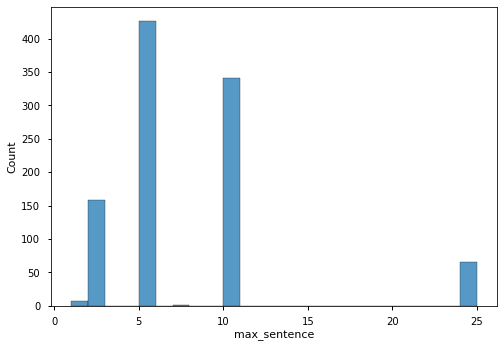

In [ ]:
sns.histplot(df['max_sentence'])

### Final Null Check

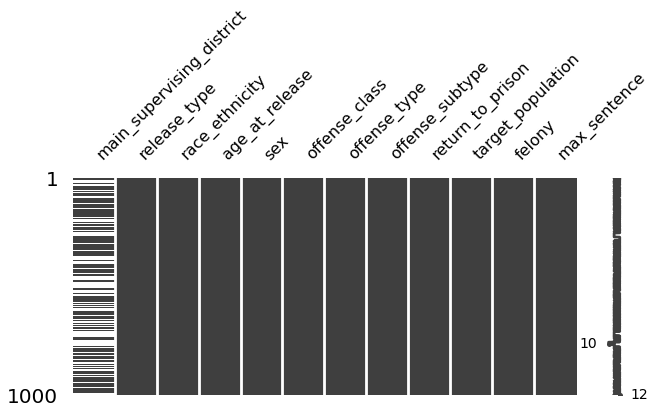

Columns with Null Values:


main_supervising_district    447
release_type                   2
dtype: int64

In [ ]:
nulls_report(df)

# Preprocessing with  Pipelines and ColumnTransformer

In [ ]:
# from sklearn.pipeline import Pipeline,make_pipeline
# from sklearn.compose import ColumnTransformer

# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import (StandardScaler, MinMaxScaler,RobustScaler,
#                                    OneHotEncoder)

# from sklearn.model_selection import train_test_split

In [ ]:
from sklearn import set_config
set_config(display='diagram')

In [ ]:
## Make x and y
target = 'return_to_prison'
X = df.drop(columns=target).copy()
y = df[target].copy()#.map( {'No':0,'Yes':1})
value_counts(y)

0   0.71
1   0.29
Name: return_to_prison.value_counts(normalized=True, dropna=False), dtype: float64

In [ ]:
## Binary columns
X.columns[X.nunique() == 2]

Index(['sex', 'target_population', 'felony'], dtype='object')

In [ ]:
X.dtypes

main_supervising_district      object
release_type                   object
race_ethnicity                 object
age_at_release                  int64
sex                          category
offense_class                  object
offense_type                   object
offense_subtype                object
target_population            category
felony                       category
max_sentence                  float64
dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,
                                                    random_state=SEED)
X_train

,main_supervising_district,release_type,race_ethnicity,age_at_release,sex,offense_class,offense_type,offense_subtype,target_population,felony,max_sentence
286,4JD,Parole,White - Non-Hispanic,50,1,C Felony,Property,Arson,1,True,10.00
71,NaN,Discharged – End of Sentence,Asian or Pacific Islander - Non-Hispanic,30,1,Aggravated Misdemeanor,Property,Vandalism,0,False,2.00
86,NaN,Discharged – End of Sentence,White - Non-Hispanic,30,1,Aggravated Misdemeanor,Property,Theft,0,False,2.00
17,7JD,Parole,White - Non-Hispanic,40,0,D Felony,Property,Theft,1,True,5.00
498,5JD,Parole,Black - Non-Hispanic,50,1,Aggravated Misdemeanor,Public Order,Traffic,1,False,2.00
...,...,...,...,...,...,...,...,...,...,...,...
527,NaN,Discharged – End of Sentence,White - Non-Hispanic,40,1,D Felony,Property,Theft,0,True,5.00
176,5JD,Special Sentence,White - Non-Hispanic,40,1,Aggravated Misdemeanor,Violent,Sex,1,False,2.00
368,NaN,Discharged – End of Sentence,White - Non-Hispanic,40,1,D Felony,Property,Burglary,0,True,5.00
211,5JD,Parole,White - Non-Hispanic,50,1,C Felony,Violent,Assault,1,True,10.00


- Plan is to make 1 ColumnTransformer without scaling, then to add scaling as a step in a modeling pipeline

In [ ]:
X_train.dtypes

main_supervising_district      object
release_type                   object
race_ethnicity                 object
age_at_release                  int64
sex                          category
offense_class                  object
offense_type                   object
offense_subtype                object
target_population            category
felony                       category
max_sentence                  float64
dtype: object

In [ ]:
## 
binary_cols = X_train.select_dtypes('category').columns
binary_cols

Index(['sex', 'target_population', 'felony'], dtype='object')

In [ ]:
## categotical columns to encode
cat_cols = list(X_train.select_dtypes('object').columns)
cat_cols

['main_supervising_district',
 'release_type',
 'race_ethnicity',
 'offense_class',
 'offense_type',
 'offense_subtype']

In [ ]:
## Get a list of columns to be run as numeric data
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['age_at_release', 'max_sentence'], dtype='object')

In [ ]:
## make sure no cols missed
[c for c in X_train.columns if c not in [*num_cols,*cat_cols,*binary_cols]]

[]

In [ ]:
from sklearn import set_config,clone
set_config(display='diagram')

In [ ]:
## Make a num_transformer pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])
num_transformer

In [ ]:
# num_transformer_reg = clone(num_transformer)
# num_transformer_reg.steps.append(('scaler',StandardScaler()))
# num_transformer_reg

In [ ]:
## Create a cat_transformer pipeline 
cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False))])#handle_unknown='ignore',
cat_transformer

### Combine Preprocessing into one ColumnTransformer

In [ ]:
## COMBINE BOTH PIPELINES INTO ONE WITH COLUMN TRANSFORMER
from sklearn.compose import ColumnTransformer
preprocessing = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('binary','passthrough',binary_cols),
    ('cat', cat_transformer, cat_cols)
])
preprocessing

In [ ]:
# preprocessing_reg = ColumnTransformer(transformers=[
#     ('num',num_transformer_reg,num_cols),
#     ('cat',cat_transformer,cat_cols),
#     ])
# preprocessing

In [ ]:
## Get X_train and X_test from column transformer
preprocessing.fit(X_train,y_train)
cat_features = preprocessing.named_transformers_['cat']\
                    .named_steps['encoder'].get_feature_names(cat_cols)
cat_features

array(['main_supervising_district_1JD', 'main_supervising_district_2JD',
       'main_supervising_district_3JD', 'main_supervising_district_4JD',
       'main_supervising_district_5JD', 'main_supervising_district_6JD',
       'main_supervising_district_7JD', 'main_supervising_district_8JD',
       'main_supervising_district_MISSING',
       'release_type_Discharged – End of Sentence',
       'release_type_MISSING', 'release_type_Parole',
       'release_type_Special Sentence',
       'race_ethnicity_American Indian or Alaska Native - Hispanic',
       'race_ethnicity_American Indian or Alaska Native - Non-Hispanic',
       'race_ethnicity_Asian or Pacific Islander - Non-Hispanic',
       'race_ethnicity_Black - Non-Hispanic',
       'race_ethnicity_White - Hispanic',
       'race_ethnicity_White - Non-Hispanic',
       'offense_class_Aggravated Misdemeanor', 'offense_class_B Felony',
       'offense_class_C Felony', 'offense_class_D Felony',
       'offense_class_Felony - Enhanced', 'o

In [ ]:
## Get full list of features

columns = [*num_cols,*binary_cols, *cat_features]
len(columns)
# columns=[*num_cols,*cat_cols,*encoded_cols]

60

In [ ]:
preprocessing.transform(X_train).shape,preprocessing.transform(X_test).shape

((750, 60), (250, 60))

In [ ]:
## Transform X_train/X_test and remake df
X_train_tf = pd.DataFrame(preprocessing.transform(X_train),
                          columns=columns,index=X_train.index)
X_test_tf = pd.DataFrame(preprocessing.transform(X_test),
                          columns=columns,index=X_test.index)
X_train_tf

,age_at_release,max_sentence,sex,target_population,felony,main_supervising_district_1JD,main_supervising_district_2JD,main_supervising_district_3JD,main_supervising_district_4JD,main_supervising_district_5JD,main_supervising_district_6JD,main_supervising_district_7JD,main_supervising_district_8JD,main_supervising_district_MISSING,release_type_Discharged – End of Sentence,release_type_MISSING,release_type_Parole,release_type_Special Sentence,race_ethnicity_American Indian or Alaska Native - Hispanic,race_ethnicity_American Indian or Alaska Native - Non-Hispanic,race_ethnicity_Asian or Pacific Islander - Non-Hispanic,race_ethnicity_Black - Non-Hispanic,race_ethnicity_White - Hispanic,race_ethnicity_White - Non-Hispanic,offense_class_Aggravated Misdemeanor,offense_class_B Felony,offense_class_C Felony,offense_class_D Felony,offense_class_Felony - Enhanced,offense_class_Other Felony,offense_class_Serious Misdemeanor,offense_class_Sex Offender,offense_type_Drug,offense_type_Other,offense_type_Property,offense_type_Public Order,offense_type_Violent,offense_subtype_Alcohol,offense_subtype_Arson,offense_subtype_Assault,offense_subtype_Burglary,offense_subtype_Drug Possession,offense_subtype_Flight/Escape,offense_subtype_Forgery/Fraud,offense_subtype_Kidnap,offense_subtype_Murder/Manslaughter,offense_subtype_OWI,offense_subtype_Other Criminal,offense_subtype_Other Drug,offense_subtype_Other Violent,offense_subtype_Prostitution/Pimping,offense_subtype_Robbery,offense_subtype_Sex,offense_subtype_Sex Offender Registry/Residency,offense_subtype_Special Sentence Revocation,offense_subtype_Theft,offense_subtype_Traffic,offense_subtype_Trafficking,offense_subtype_Vandalism,offense_subtype_Weapons
286,50.00,10.00,1,1,True,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
71,30.00,2.00,1,0,False,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
86,30.00,2.00,1,0,False,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
17,40.00,5.00,0,1,True,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
498,50.00,2.00,1,1,False,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,40.00,5.00,1,0,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
176,40.00,2.00,1,1,False,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [ ]:
X_train_tf.isna().sum()

age_at_release                                                    0
max_sentence                                                      0
sex                                                               0
target_population                                                 0
felony                                                            0
main_supervising_district_1JD                                     0
main_supervising_district_2JD                                     0
main_supervising_district_3JD                                     0
main_supervising_district_4JD                                     0
main_supervising_district_5JD                                     0
main_supervising_district_6JD                                     0
main_supervising_district_7JD                                     0
main_supervising_district_8JD                                     0
main_supervising_district_MISSING                                 0
release_type_Discharged – End of Sentence       

## Modeling Functions

In [ ]:
import sklearn.metrics as metrics

def evaluate_classification(model,X_test,y_test,classes=['Non Recid','Recidivst'],
                           normalize='true',cmap='Purples',label='',
                           return_report=False):
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f":\t{label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    if return_report:
        return report #fig,axes

In [ ]:
def get_feature_importance(clf,X_train_tf,plot=True):
    importances = pd.Series(clf.feature_importances_,index=X_train_tf.columns)
    return importances.sort_values(ascending=False)

def plot_importance(clf,X_train_tf,n=25,figsize=(4,8),style='seaborn-talk',
                   clean_names=True):
    importances = get_feature_importance(clf,X_train_tf)
    
    if clean_names:
        importances.index= [c.replace('_',' ').title() for c in importances.index]
    
    with plt.style.context(style):
        ax = importances.sort_values().tail(n).plot(kind='barh',figsize=figsize)
        ax.set(title=f"Top {n} Most Important Features",xlabel='importance')

## Baseline DummyClassifier

------------------------------------------------------------
	CLASSIFICATION REPORT - Dummy Classifier
------------------------------------------------------------
              precision    recall  f1-score   support

    No-Recid       0.69      0.63      0.66       178
   Yes-Recid       0.25      0.31      0.28        72

    accuracy                           0.54       250
   macro avg       0.47      0.47      0.47       250
weighted avg       0.57      0.54      0.55       250



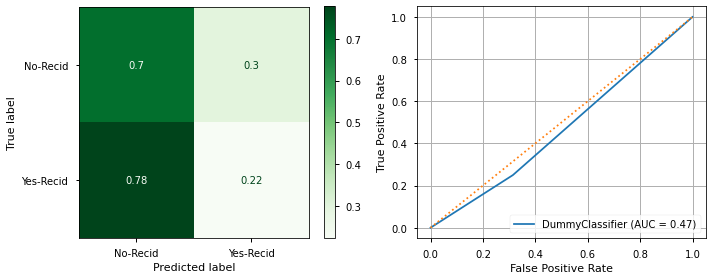

In [ ]:
from sklearn.dummy import DummyClassifier

dummy= DummyClassifier(strategy='stratified')
dummy.fit(X_train_tf,y_train)
ji.evaluate_classification(dummy,X_test_tf,y_test,
                       label='Dummy Classifier')

- Our Dummy Classifier performed terribly, as it should. The imbalanced nature of the classes is very apparently in the recall values for 0 and 1 

## Random Forests

### RF #1: Vanilla RandomForest (Imbalanced Data)

------------------------------------------------------------
	CLASSIFICATION REPORT - Vanilla Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

    No-Recid       0.77      0.85      0.81       178
   Yes-Recid       0.51      0.39      0.44        72

    accuracy                           0.72       250
   macro avg       0.64      0.62      0.63       250
weighted avg       0.70      0.72      0.70       250



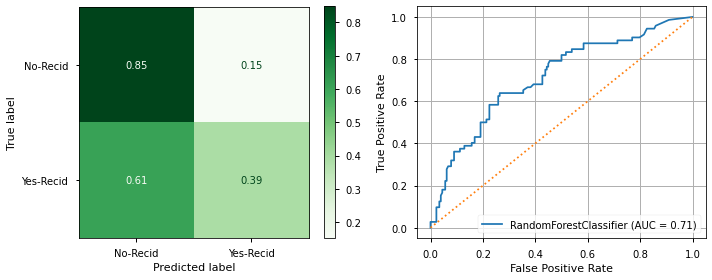

Training Score = 0.96
Test Score = 0.72


In [ ]:
rf1 = RandomForestClassifier(random_state=SEED)
rf1.fit(X_train_tf,y_train)


ji.evaluate_classification(rf1,X_test_tf,y_test,X_train=X_train_tf,
                           y_train=y_train,label="Vanilla Random Forest")


### RF #2 - `class_weight="balanced"`

------------------------------------------------------------
	CLASSIFICATION REPORT - Random Forest (class_weight='balanced')
------------------------------------------------------------
              precision    recall  f1-score   support

    No-Recid       0.79      0.86      0.82       178
   Yes-Recid       0.55      0.43      0.48        72

    accuracy                           0.74       250
   macro avg       0.67      0.65      0.65       250
weighted avg       0.72      0.74      0.73       250



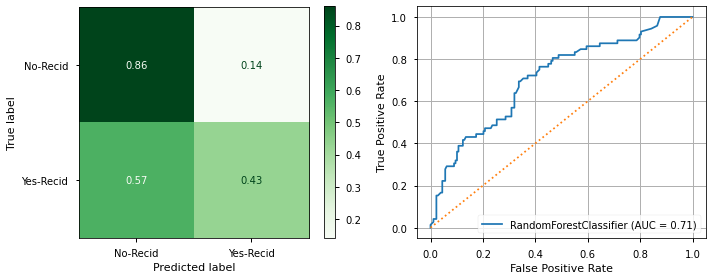

Training Score = 0.96
Test Score = 0.74


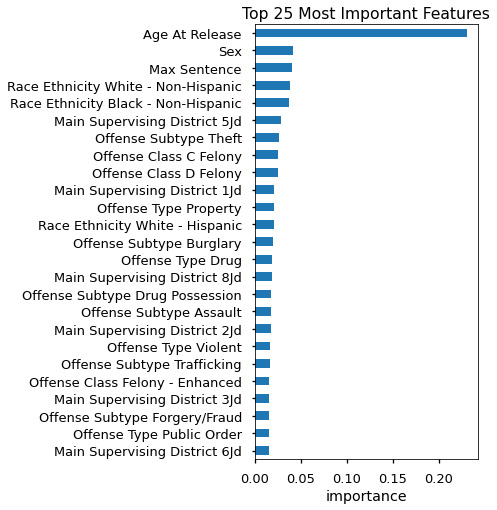

In [ ]:
rf2 = RandomForestClassifier(class_weight='balanced',random_state=SEED)
rf2.fit(X_train_tf,y_train)
ji.evaluate_classification(rf2,X_test_tf,y_test,X_train=X_train_tf,y_train=y_train,
                           label= "Random Forest (class_weight='balanced')")
plot_importance(rf2,X_test_tf)

In [ ]:
# rf3 = RandomForestClassifier(class_weight='balanced_subsample',random_state=SEED)
# rf3.fit(X_train_tf,y_train)
# ji.evaluate_classification(rf3,X_test_tf,y_test,X_train=X_train_tf,y_train=y_train,
#                            label= "Random Forest (class_weight='balanced')")
# plot_importance(rf3,X_test_tf)

### RF- Pipe

------------------------------------------------------------
	CLASSIFICATION REPORT - Vanilla Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

    No-Recid       0.79      0.86      0.82       178
   Yes-Recid       0.55      0.43      0.48        72

    accuracy                           0.74       250
   macro avg       0.67      0.65      0.65       250
weighted avg       0.72      0.74      0.73       250



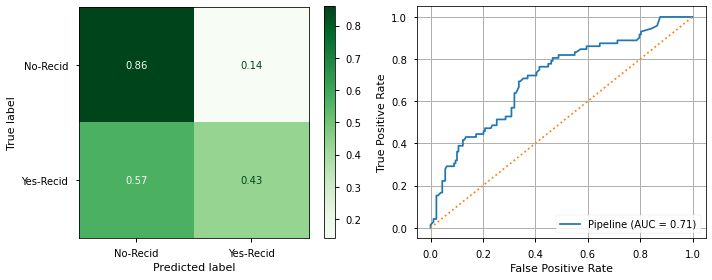

Training Score = 0.96
Test Score = 0.74


In [ ]:
## Making a Pipeline/GridSearch to confirm if scaling makes a diff
rf_pipe = Pipeline(steps=[
    ('scaler',StandardScaler()), 
    ('clf',RandomForestClassifier(random_state=SEED, class_weight='balanced'))
     ])
rf_pipe.fit(X_train_tf,y_train)


ji.evaluate_classification(rf_pipe,X_test_tf,y_test,X_train=X_train_tf,
                           y_train=y_train,label="Vanilla Random Forest")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.2s finished


{'clf__class_weight': 'balanced_subsample', 'scaler': 'passthrough'}
------------------------------------------------------------
	CLASSIFICATION REPORT - GridSearch Best Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

    No-Recid       0.78      0.84      0.81       178
   Yes-Recid       0.50      0.40      0.45        72

    accuracy                           0.71       250
   macro avg       0.64      0.62      0.63       250
weighted avg       0.70      0.71      0.70       250



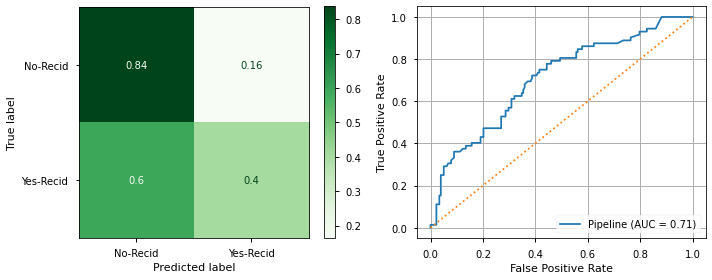

Training Score = 0.96
Test Score = 0.71


In [ ]:
## Gridsearch for scaling and class_weight

params = {'scaler':['passthrough',StandardScaler(),MinMaxScaler(),RobustScaler()],
         'clf__class_weight':[None, 'balanced','balanced_subsample']}
grid = GridSearchCV(rf_pipe, params, verbose=True,n_jobs=-1,scoring='f1')

grid.fit(X_train_tf,y_train)
print(grid.best_params_)
ji.evaluate_classification(grid.best_estimator_,X_test_tf,y_test,
                           X_train=X_train_tf, y_train=y_train,
                           label="GridSearch Best Random Forest")

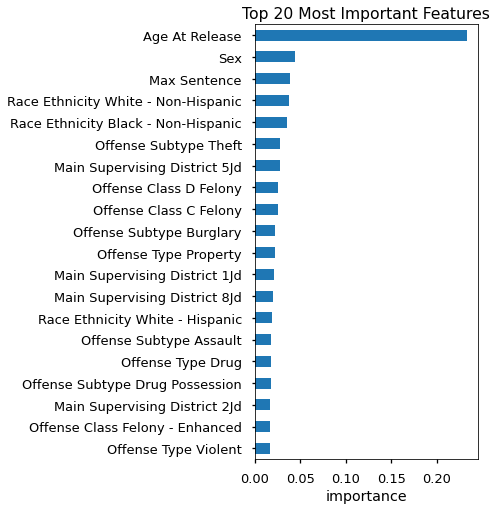

In [ ]:
plot_importance(grid.best_estimator_.named_steps['clf'], X_test_tf,n=20)

- Regardless of which parameter for class_weight, the class imbalance is heavily skewing the models' predictions towards non-recidivist.
- We will use SMOTE to oversampling our minority class in the training set. 

## SMOTENC for Class Imbalance

- Since our dataset contains categorical features, we must use the SMOTENC class from imblearn, instead of the normal SMOTE class. 
- This class requires an index of categorical features and handles them differently than numeric features.

In [ ]:
from imblearn.over_sampling import SMOTENC

In [ ]:
## Getting cat features index
cat_col_index = [False for col in num_cols]
cat_col_index.extend([True for col in binary_cols])

cat_col_index.extend([True for col in cat_features])
X_train_tf.columns[cat_col_index]

Index(['sex', 'target_population', 'felony', 'main_supervising_district_1JD',
       'main_supervising_district_2JD', 'main_supervising_district_3JD',
       'main_supervising_district_4JD', 'main_supervising_district_5JD',
       'main_supervising_district_6JD', 'main_supervising_district_7JD',
       'main_supervising_district_8JD', 'main_supervising_district_MISSING',
       'release_type_Discharged – End of Sentence', 'release_type_MISSING',
       'release_type_Parole', 'release_type_Special Sentence',
       'race_ethnicity_American Indian or Alaska Native - Hispanic',
       'race_ethnicity_American Indian or Alaska Native - Non-Hispanic',
       'race_ethnicity_Asian or Pacific Islander - Non-Hispanic',
       'race_ethnicity_Black - Non-Hispanic',
       'race_ethnicity_White - Hispanic',
       'race_ethnicity_White - Non-Hispanic',
       'offense_class_Aggravated Misdemeanor', 'offense_class_B Felony',
       'offense_class_C Felony', 'offense_class_D Felony',
       'offen

### 🎛SMOTENC params

### RF #3: RandomForest with SMOTE'd Data

------------------------------------------------------------
	CLASSIFICATION REPORT - RandomForest - SMOTE
------------------------------------------------------------
              precision    recall  f1-score   support

    No-Recid       0.81      0.84      0.83       178
   Yes-Recid       0.57      0.51      0.54        72

    accuracy                           0.75       250
   macro avg       0.69      0.68      0.68       250
weighted avg       0.74      0.75      0.74       250



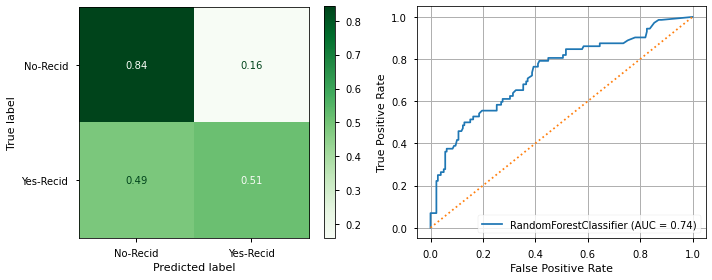

Training Score = 0.96
Test Score = 0.75


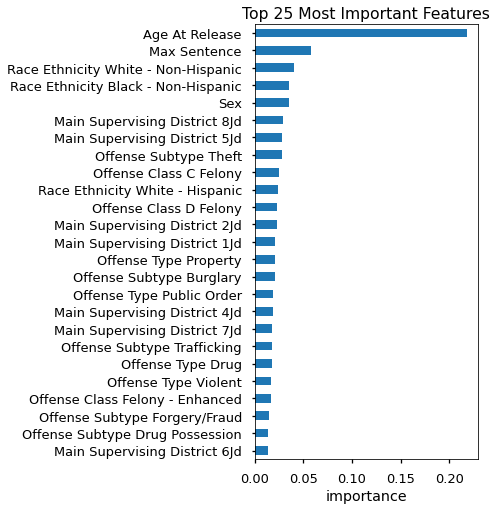

In [ ]:
# SMOTE_SEED = 432


smote = SMOTENC(cat_col_index,random_state=SMOTE_SEED,
                k_neighbors=5, n_jobs=-1)

X_train_smote,y_train_smote = smote.fit_resample(X_train_tf,y_train)
y_train_smote.value_counts()
### SPLIT HERE ###
rf3 = RandomForestClassifier()#random_state=SEED)#class_weight='balanced')
rf3.fit(X_train_smote,y_train_smote)
ji.evaluate_classification(rf3,X_test_tf,y_test,
                           X_train=X_train_smote,
                           y_train=y_train_smote,
                           label='RandomForest - SMOTE')
plot_importance(rf3,X_test_tf)

- Resampling with SMOTE has improved our model's ability to predict the target class (recall went from 0.4 - 0.5), but overall the model is still lacking and accuracy has decreased as well.

### RF GridSearch 

```python
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

clf = RandomForestClassifier()
params ={'max_depth':[None,5,7,10,20,30,],
         'min_samples_leaf':[1,2,3],
         'criterion':['gini','entropy'],        
        }


grid = GridSearchCV(clf,params,scoring='recall_macro', n_jobs=-1)

grid.fit(X_train_smote,y_train_smote)
print(grid.best_params_)

print(grid.best_score_)
evaluate_classification(grid.best_estimator_,X_test_tf,y_test)
```

<AxesSubplot:ylabel='Count'>

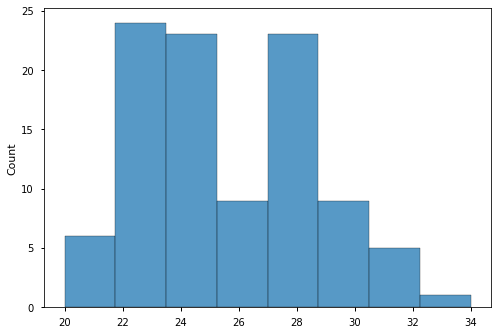

In [ ]:
## Checking depths of trees in the forest
depths = [tree.get_depth() for tree in rf3.estimators_]
sns.histplot(depths)

In [ ]:
rf_pipe = Pipeline(steps=[
    ('scaler',StandardScaler()), 
    ('clf',RandomForestClassifier(class_weight='balanced'))
     ])

params ={'scaler':['passthrough',StandardScaler(),MinMaxScaler()],
         'clf__class_weight':[None,'balanced','balanced_subsample'],
         'clf__max_depth':[None,15,20,25,30],
         'clf__min_samples_leaf':[1,2,3],
#          'clf__min_samples_split':[2,3],
         'clf__criterion':['gini','entropy'], 
         'clf__n_estimators':[50,100,150]
        }

grid = GridSearchCV(rf_pipe, params, verbose=True,
                    n_jobs=-1,cv=3,scoring='recall_macro')

grid.fit(X_train_tf,y_train)

{'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 50, 'scaler': StandardScaler()}
0.621863538640317
------------------------------------------------------------
	CLASSIFICATION REPORT - Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

    No-Recid       0.78      0.79      0.78       178
   Yes-Recid       0.46      0.44      0.45        72

    accuracy                           0.69       250
   macro avg       0.62      0.62      0.62       250
weighted avg       0.69      0.69      0.69       250



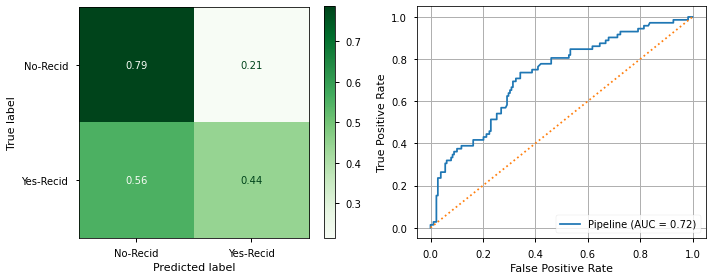

Training Score = 0.95
Test Score = 0.69


In [ ]:
print(grid.best_params_)
print(grid.best_score_)
ji.evaluate_classification(grid.best_estimator_,X_test_tf,y_test,
                           X_train=X_train_tf,y_train=y_train)

### Random Forest Observations/Summary

- Random Forests seem to have a hard time learning about the minority class- Return-to_prison = Yes

# MODELING- Part 2

- Finally, we will try 2 final model types, Support Vector Classifier and Logistic Regression.
- Both of these models require scaled data for correct performance. 